## Exercise - DL Tutorial 09

### Student names: Benedikt Bauer, David Heim, Franz Schulze

Submit you solution by 07 July 23:59 to manuel.milling@informatik.uni-augsburg.de or maurice.gerczuk@informatik.uni-augsburg.de

In [31]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LeakyReLU, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv2D, UpSampling2D, Reshape,  MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import os
import glob
import scipy.misc
from IPython.display import clear_output, Image
import math

### Ring GAN

In [32]:
# Objective function; Achieve at least .8 with the test vector
def ring_objective(preds):
    dists = np.sqrt(preds[:, 0] ** 2 + preds[:, 1] ** 2).reshape(-1)
    return np.mean(np.where(np.abs(dists - 1) <= 0.1, 1, 0))

In [33]:
SAMPLE_DIM = 2
ITERATIONS = 16001
CIRCLE_RADIUS = 1

Define discriminator architecture.

In [34]:
def discriminator():
    model = Sequential(name='discriminator')
    model.add(Dense(32, input_dim=SAMPLE_DIM))
    model.add(LeakyReLU())
    model.add(Dense(16))
    model.add(LeakyReLU())
    model.add(Dense(4))
    model.add(LeakyReLU())
    model.add(Dense(1, activation='sigmoid'))
    return model

Define generator architecture.

In [35]:
def generator():
    net = Sequential(name='generator')
    net.add(Dense(32, input_dim=SAMPLE_DIM))
    net.add(LeakyReLU())
    net.add(Dense(16))
    net.add(LeakyReLU())
    net.add(Dense(4))
    net.add(LeakyReLU())
    net.add(Dense(2))
    return net

Define and compile GAN architecture.

In [36]:
generator = generator()
discriminator = discriminator()


optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.trainable = False

generator.compile(loss='mse', optimizer=optimizer)

gan = Sequential(name='gan')
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator.summary()
discriminator.summary()
gan.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                96        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 68        
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 4)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 10

Generate training data.

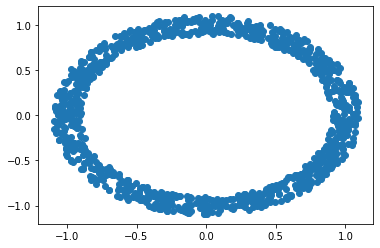

In [37]:
angles = np.random.uniform(0, 2 * math.pi, size=[1024, 1])
r_rads = np.random.uniform(0.9, 1.1, size=[1024, 1])
x_train = np.hstack((np.cos(angles) * CIRCLE_RADIUS * r_rads, np.sin(angles) * CIRCLE_RADIUS * r_rads))


plt.scatter(x_train[:, 0], x_train[:, 1])

plt.show()

Train GAN.

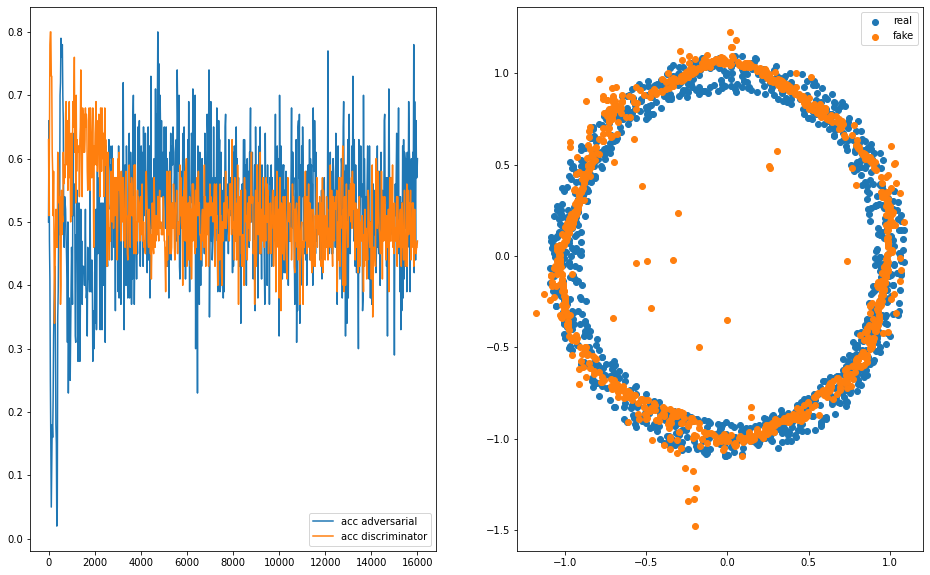

Objective score: 0.935


In [38]:
vis_noise = np.random.normal(0, 1.0, size=[1000, SAMPLE_DIM])

acc_adv = []
acc_dis = []
plot_iteration = []
batch_size = 100

fake_labels = np.zeros((batch_size // 2, 1))
real_labels = np.ones((batch_size // 2, 1))
combined_labels = np.vstack((real_labels, fake_labels))
real_label_gan = np.ones((batch_size, 1))

for i in range(ITERATIONS):

    # TODO: Add GAN training.
    
    # Train the discriminator
    idx = np.random.randint(0, x_train.shape[0], batch_size // 2)
    real_data = x_train[idx]
    gen_data = generator.predict(np.random.normal(0, 1.0, size=[batch_size // 2, SAMPLE_DIM]))
    combined_data = np.vstack((real_data, gen_data))
    discriminator_stats = discriminator.train_on_batch(combined_data, combined_labels)

    noise = np.random.normal(0, 1.0, size=[batch_size, SAMPLE_DIM])
    adversarial_stats = gan.train_on_batch(noise, real_label_gan)
    
    # Visualization: Plot the accuracy of the discriminator and the adversarial setup + the
    # predicted point cloud from the test vector.
    if i % 20 == 0:
        plot_iteration.append(i)
        # Don't forget to include the accuracy metric when compiling the models.
        acc_adv.append(adversarial_stats[1])
        acc_dis.append(discriminator_stats[1])

        clear_output(wait=True)

        fig, axes = plt.subplots(1,2)
        fig.set_size_inches(16, 10)

        axes[0].plot(plot_iteration, acc_adv, label="acc adversarial")
        axes[0].plot(plot_iteration, acc_dis, label="acc discriminator")
        axes[0].legend()

        # Visualize the performance of the generator by producing samples from the test vector.
        generated = generator.predict(vis_noise)

        axes[1].scatter(x_train[:,0], x_train[:,1], label="real")
        axes[1].scatter(generated[:,0], generated[:,1], label="fake")
        axes[1].legend()
        plt.show()

        print("Objective score:", ring_objective(generated))


### MNIST GAN

In [60]:
ITERATIONS = 10001
# I suggest using uniform random noise vectors of size 100.
SAMPLE_DIM = 100
IMAGE_SHAPE = [28, 28, 1]

Define discriminator architecture.

In [61]:
def define_mnist_discriminator(image_shape):
    model = Sequential(name='disc')
    model.add(Flatten(input_shape=image_shape))
    model.add(Dense(1024))
    model.add(LeakyReLU())
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(Dense(1, activation='sigmoid'))
    return model

Define generator architecture.

In [62]:
def define_mnist_generator(sample_dim, image_shape):
    model = Sequential(name='gen')
    model.add(Dense(256, input_dim=sample_dim))  
    model.add(LeakyReLU())
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(Dense(1024))
    model.add(LeakyReLU())
    model.add(Dense(np.prod(image_shape), activation='tanh'))
    model.add(Reshape(image_shape))
    return model

In [63]:
opt = Adam(0.0002, 0.5)
discriminator = define_mnist_discriminator(IMAGE_SHAPE)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

generator = define_mnist_generator(SAMPLE_DIM, IMAGE_SHAPE)
discriminator.trainable = False
gan = Sequential(name='GAN')
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

generator.summary()
discriminator.summary()
gan.summary()

Model: "gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 784)               803600  

Load mnist training data.

In [64]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train / 127.5 - 1
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

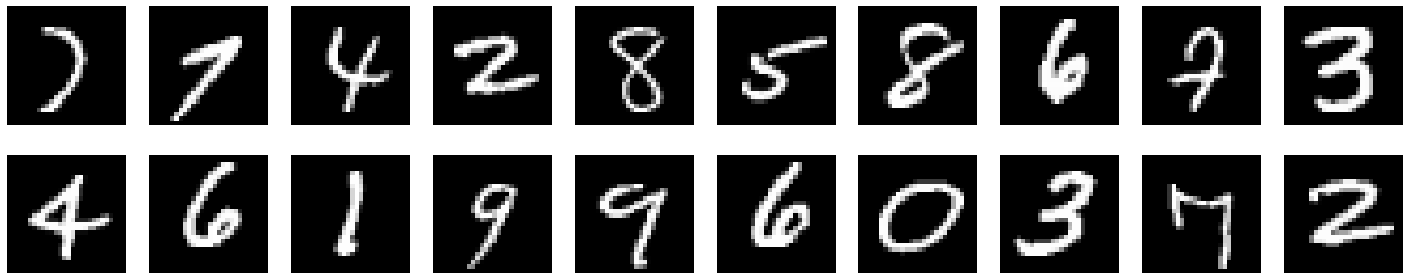

In [65]:
images = x_train[140:160]

plt.figure(figsize=(25, 5))

for im in range(images.shape[0]):
    plt.subplot(2, 10, im + 1)
    image = images[im, :, :, :]
    image = np.reshape(image, [28, 28])

    plt.imshow(image, cmap='gray')
    plt.axis('off')

Train GAN.

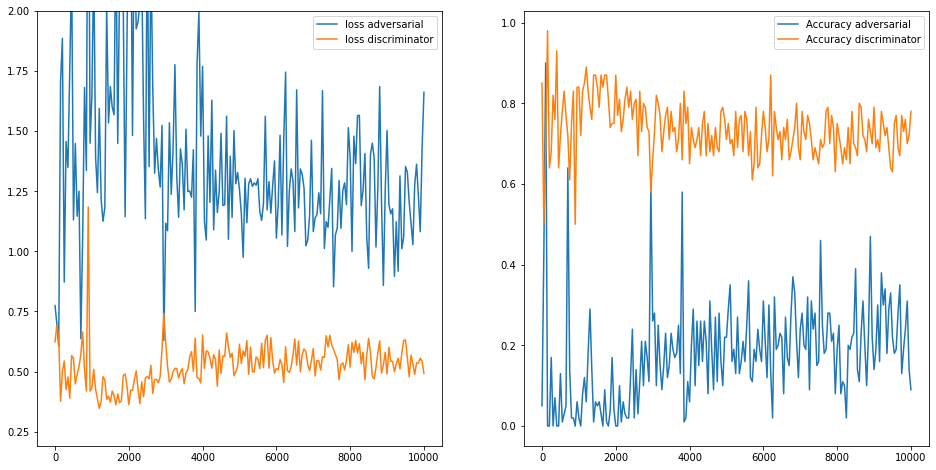

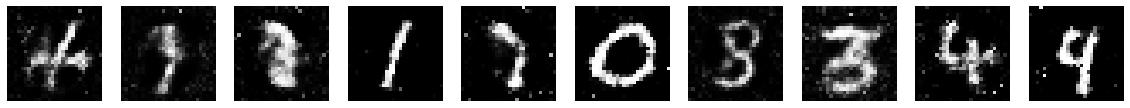

In [66]:
loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []


test_noise = np.random.uniform(-1.0, 1.0, size=[10, SAMPLE_DIM])

valid = np.ones((batch_size, 1))
valid_half = np.ones((batch_size//2, 1))
fake = np.zeros((batch_size//2, 1))

for i in range(ITERATIONS):

    # TODO: Add GAN training.
    idx = np.random.randint(0, x_train.shape[0], batch_size // 2)
    images = x_train[idx]
    noise = np.random.normal(0, 1.0, size=[batch_size//2, SAMPLE_DIM])
    generated_images = generator.predict(noise)
    combined_data = np.vstack((images, generated_images))
    combined_labels = np.vstack((valid_half, fake))

    d_stats = discriminator.train_on_batch(combined_data, combined_labels)
    noise = np.random.normal(0, 1, (batch_size, SAMPLE_DIM))
    a_stats = gan.train_on_batch(noise, valid)
    if i % 50 == 0:

        clear_output(wait=True)

        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax[0].plot(plot_iteration, loss_adv, label="loss adversarial")
        ax[0].plot(plot_iteration, loss_dis, label="loss discriminator")
        ax[0].legend()
        ax[0].set_ylim(top=2)

        ax[1].plot(plot_iteration, acc_adv, label="Accuracy adversarial")
        ax[1].plot(plot_iteration, acc_dis, label="Accuracy discriminator")
        ax[1].legend()
        
        test_samples = generator.predict(test_noise)
        
        
        plt.figure(figsize=(20,10))

        for im in range(test_samples.shape[0]):
            plt.subplot(1, 10, im+1)
            image = test_samples[im, :, :, :]
            image = np.reshape(image, [28, 28])

            plt.imshow(image, cmap='gray')
            plt.axis('off')

        plt.show()
